# Initialization

This Jupyter Notebook provides the analysis results of our emperical analysis paper for on-chain voting smart contracts. A Google Cloud account is needed for executing the commands, however the results are available here.

Imports:
- Google Cloud service libraries for BigQuery and Google Drive
- Pandas
- Numpy

In [ ]:
# Google
from google.cloud import bigquery
from google.colab import drive

# Data
import pandas as pd
import numpy as np

# Set locale for uniform thounsands-separator
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

Request authentication tokens for BigQuery and Google Drive (Spread Sheet).

In [ ]:
# Authenticate
from google.colab import auth
auth.authenticate_user()

# Init BigQuery
client = bigquery.Client(project='evotinggasanalysis')

In [ ]:
# Google Drive / Spread Sheet
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Ethereum

In [ ]:
# Constants
dataset = '20201027'
maxBlock = '2020-10-30'

## Signatures

In [ ]:
votingSigns = pd.DataFrame(columns=['hash', 'signature', 'source', 'keyword'])

### ERC-1202

In [ ]:
# Source: https://github.com/ethereum/EIPs/blob/master/EIPS/eip-1202.md
erc1202Signs = pd.read_json('[{"hash": "0xb384abef","is_erc1202": true,"signature": "vote(uint256,uint256)"},{"hash": "0x8719e8ac","is_erc1202": true,"signature": "setStatus(uint256,bool)"},{"hash": "0x1e01a172","is_erc1202": true,"signature": "issueDescription(uint256)"},{"hash": "0xc36fff2d","is_erc1202": true,"signature": "availableOptions(uint256)"},{"hash": "0xea2bc862","is_erc1202": true,"signature": "optionDescription(uint256,uint256)"},{"hash": "0x32ec991c","is_erc1202": true,"signature": "ballotOf(uint256,address)"},{"hash": "0x8935ced5","is_erc1202": true,"signature": "weightOf(uint256,address)"},{"hash": "0x5c622a0e","is_erc1202": true,"signature": "getStatus(uint256)"},{"hash": "0x6e6a1dc3","is_erc1202": true,"signature": "weightedVoteCountsOf(uint256,uint256)"},{"hash": "0xaff9e954","is_erc1202": true,"signature": "topOptions(uint256,uint256)"}]')
erc1202Signs["source"] = "ERC-1202" 
erc1202Signs.pop("is_erc1202")
votingSigns = votingSigns.append(erc1202Signs)

### DAO

In [ ]:
# Source: https://github.com/TheDAO/DAO-1.0/blob/master/DAO.sol
# Signature calculator: https://piyolab.github.io/playground/ethereum/getEncodedFunctionSignature/
thedaoSigns = pd.read_json('[{"hash": "0x612e45a3", "signature": "newProposal(address,uint256,string,bytes,uint256,bool)"},{"hash": "0xeceb2945", "signature": "checkProposalCode(uint256,address,uint256,bytes)"},{"hash": "0xc9d27afe", "signature": "vote(uint256,bool)"},{"hash": "0x237e9492", "signature": "executeProposal(uint256,bytes)"},{"hash": "0x6837ff1e", "signature": "newContract(address)"},{"hash": "0x749f9889", "signature": "changeAllowedRecipients(address,bool)"},{"hash": "0xe33734fd", "signature": "changeProposalDeposit(uint256)"},{"hash": "0x78524b2e", "signature": "halveMinQuorum()"},{"hash": "0x8d7af473", "signature": "numberOfProposals()"},{"hash": "0x2632bf20", "signature": "unblockMe()"}]')
thedaoSigns["source"] = "The DAO"
votingSigns = votingSigns.append(thedaoSigns)

### 4byte.directory

In [ ]:
keywords = ['voting', 'vote', 'ballot']

for keyword in keywords:
  nextUrl = 'https://www.4byte.directory/api/v1/signatures/?format=json&text_signature=' + keyword

  readSigns = pd.DataFrame(columns=votingSigns.columns)

  while type(nextUrl) is str:
    print("Load url: " + nextUrl)
    readJson = pd.read_json(nextUrl)

    nextUrl = readJson.loc[0]['next']

    if readJson.loc[0]['count'] != np.NaN and readJson.loc[0]['count'] > 0:
      data = {'signature': readJson['results'].map(lambda x: x['text_signature']),
              'hash':      readJson['results'].map(lambda x: x['hex_signature']),
              'source':    readJson['results'].map(lambda x: '4byte.directory' ),
              'keyword':   readJson['results'].map(lambda x: keyword )}

      rows = pd.DataFrame(data, columns=votingSigns.columns)
      readSigns = readSigns.append(rows)

  votingSigns = votingSigns.append(readSigns)


Load url: https://www.4byte.directory/api/v1/signatures/?format=json&text_signature=voting
Load url: https://www.4byte.directory/api/v1/signatures/?format=json&page=2&text_signature=voting
Load url: https://www.4byte.directory/api/v1/signatures/?format=json&page=3&text_signature=voting
Load url: https://www.4byte.directory/api/v1/signatures/?format=json&text_signature=vote
Load url: https://www.4byte.directory/api/v1/signatures/?format=json&page=2&text_signature=vote
Load url: https://www.4byte.directory/api/v1/signatures/?format=json&page=3&text_signature=vote
Load url: https://www.4byte.directory/api/v1/signatures/?format=json&page=4&text_signature=vote
Load url: https://www.4byte.directory/api/v1/signatures/?format=json&page=5&text_signature=vote
Load url: https://www.4byte.directory/api/v1/signatures/?format=json&page=6&text_signature=vote
Load url: https://www.4byte.directory/api/v1/signatures/?format=json&page=7&text_signature=vote
Load url: https://www.4byte.directory/api/v1/sig

In [ ]:
# Number of found signatures
votingSigns.shape[0]

1487

In [ ]:
votingSigns.drop_duplicates("signature", inplace=True)
votingSigns.reset_index(drop=True, inplace=True)
#votingSigns.sort_index(inplace=True)
votingSigns

,hash,signature,source,keyword
0,0xb384abef,"vote(uint256,uint256)",ERC-1202,NaN
1,0x8719e8ac,"setStatus(uint256,bool)",ERC-1202,NaN
2,0x1e01a172,issueDescription(uint256),ERC-1202,NaN
3,0xc36fff2d,availableOptions(uint256),ERC-1202,NaN
4,0xea2bc862,"optionDescription(uint256,uint256)",ERC-1202,NaN
...,...,...,...,...
1467,0xf2a5630a,BallotUp(),4byte.directory,ballot
1468,0x1cff3e09,testCreateBallotContract(),4byte.directory,ballot
1469,0xb655f822,Ballot(),4byte.directory,ballot
1470,0x940f851c,Ballot(uint8),4byte.directory,ballot


In [ ]:
votingSigns[votingSigns.signature == 'vote(string)']

,hash,signature,source,keyword
1338,0xfc36e15b,vote(string),4byte.directory,vote


## Insert Signature Hashses to BigQuery

In [ ]:
# Clear table
job = client.query('DELETE FROM `evotinggasanalysis.{0}.functionSighashes` WHERE 1=1'.format(dataset))
job.result()

In [ ]:
# Inserts
chunkMod = 3 # split into 10 SQL insert statements
for i in range(0, chunkMod):
  chunk = pd.DataFrame(votingSigns[votingSigns.index % chunkMod == i])

  chunk["is_erc1202"] = chunk['source'].map(lambda x: 'true' if x == 'ERC-1202' else 'false')
  chunk["sqlValue"] = pd.Series('(\'' + chunk['hash'] + '\', \'' + chunk['signature'] + '\', ' + chunk["is_erc1202"] + ')', dtype="string")

  query = 'INSERT INTO `evotinggasanalysis.{0}.functionSighashes` (`hash`, `signature`, `is_erc1202`) VALUES '.format(dataset) + ','.join(chunk["sqlValue"].to_list())

  job = client.query(query)
  print(job.result())

## Find Voting Contracts

In [ ]:
# Clear Table
job = client.query('DELETE FROM `evotinggasanalysis.{0}.votingContracts` WHERE 1=1'.format(dataset))
job.result()

In [ ]:
# ERC-1201
query = 'INSERT INTO `evotinggasanalysis.{0}.votingContracts` SELECT address, function_sighashes, is_erc20, is_erc721, {2}, block_timestamp, block_number FROM `bigquery-public-data.crypto_ethereum.contracts` WHERE 1=1 AND DATE(block_timestamp) <= \'{1}\' AND EXISTS(SELECT 1 FROM UNNEST(function_sighashes) intersec WHERE intersec IN UNNEST(( SELECT ARRAY_AGG(`hash`) FROM evotinggasanalysis.{0}.functionSighashes WHERE is_erc1202 = {2} )))'
queryErc1202 = query.format(dataset, maxBlock, 'FALSE')
query4bdir = query.format(dataset, maxBlock, 'TRUE')

job = client.query(queryErc1202)
print(job.result())
job = client.query(query4bdir)
print(job.result())

## Cache Voting Contract Methods Count

In [ ]:
# Clear Table
job = client.query('DELETE FROM evotinggasanalysis.{0}.votingContractMethods WHERE 1=1;'.format(dataset))
job.result()

In [ ]:
job = client.query('INSERT INTO evotinggasanalysis.{0}.votingContractMethods SELECT votingContracts.address, COUNT(functionSighashes.HASH) AS voting_methods FROM evotinggasanalysis.{0}.functionSighashes, evotinggasanalysis.{0}.votingContracts votingContracts WHERE `hash` IN ( ( SELECT hashes FROM evotinggasanalysis.{0}.votingContracts innerVotingContracts, UNNEST(innerVotingContracts.function_sighashes) hashes WHERE address = votingContracts.address )) GROUP BY votingContracts.address'.format(dataset))
job.result()

## Cache Voting-related Transactions

In [ ]:
# Clear Table
job = client.query('DELETE FROM evotinggasanalysis.{0}.votingTransactions WHERE 1=1;'.format(dataset))
job.result()

In [ ]:
job = client.query('INSERT INTO `evotinggasanalysis.{0}.votingTransactions` SELECT `hash`, from_address, to_address, gas, gas_price, value, receipt_gas_used, block_number, block_timestamp, substr(input, 0, 10) as function_sighash, FROM `bigquery-public-data.crypto_ethereum.transactions` WHERE 1=1 AND receipt_contract_address IS NULL AND receipt_status = 1 AND to_address in (SELECT address FROM `evotinggasanalysis.{0}.votingContracts`) AND substr(input, 0, 10) IN (SELECT `hash` FROM `evotinggasanalysis.{0}.functionSighashes`)'.format(dataset))
job.result()

## Find DAO Contracts

In [ ]:
daoHashes = votingSigns[votingSigns["source"] == "The DAO"].hash
daoHashesWHERE = ' AND '.join(list(daoHashes.apply(lambda x: '\'' + x + '\' IN UNNEST(function_sighashes)').astype('string').values))
sql = 'SELECT COUNT(*) FROM `bigquery-public-data.crypto_ethereum.contracts` WHERE ' + daoHashesWHERE
sql

"SELECT COUNT(*) FROM `bigquery-public-data.crypto_ethereum.contracts` WHERE '0x612e45a3' IN UNNEST(function_sighashes) AND '0xeceb2945' IN UNNEST(function_sighashes) AND '0xc9d27afe' IN UNNEST(function_sighashes) AND '0x237e9492' IN UNNEST(function_sighashes) AND '0x6837ff1e' IN UNNEST(function_sighashes) AND '0x749f9889' IN UNNEST(function_sighashes) AND '0xe33734fd' IN UNNEST(function_sighashes) AND '0x78524b2e' IN UNNEST(function_sighashes) AND '0x8d7af473' IN UNNEST(function_sighashes) AND '0x2632bf20' IN UNNEST(function_sighashes)"

# Dash
Download proposals from dashcentral.org

## Proposals

In [ ]:
downloaded_proposals = None

page = 1
while page > 0:
  downloaded_json = pd.read_json("https://www.dashcentral.org/api/v1/budgethistory?pageid=" + str(page))
  
  if downloaded_json.proposals.size > 0:
    if downloaded_proposals is None:
      downloaded_proposals = downloaded_json.proposals
    else:
      downloaded_proposals = downloaded_proposals.append(downloaded_json.proposals)
    
    page += 1
  else:
    page = 0 # No more proposals available

downloaded_proposals = downloaded_proposals.reset_index()
downloaded_proposals.pop("index")
downloaded_proposals = downloaded_proposals.rename(columns={"proposals": "json"})
print("Downloaded proposals: ", downloaded_proposals.size)

Downloaded proposals:  580


In [ ]:
# Format
proposals = pd.DataFrame(downloaded_proposals)
proposals['hash'] = proposals['json'].map(lambda x: x['hash'])
proposals['add'] = proposals['json'].map(lambda x: pd.to_datetime(x['date_added']))
proposals['end'] = proposals['json'].map(lambda x: pd.to_datetime(x['voting_deadline']))
proposals['will_be_funded'] = proposals['json'].map(lambda x: x['will_be_funded'])
proposals['yes'] = proposals['json'].map(lambda x: x['yes'])
proposals['no'] = proposals['json'].map(lambda x: x['no'])
proposals['abstain'] = proposals['json'].map(lambda x: x['abstain'])
proposals['votes'] = proposals['yes'] + proposals['no'] + proposals['abstain']
proposals['fund'] = proposals['json'].map(lambda x: x['monthly_amount'])
proposals['year'] = proposals['end'].map(lambda x: x.year)
proposals.head()

,json,hash,add,end,will_be_funded,yes,no,abstain,votes,fund,year
0,{'hash': 'f9b0d75a3f7ba06e230104fd222d09dc43d1...,f9b0d75a3f7ba06e230104fd222d09dc43d184c0bf3b63...,2020-11-03 16:10:01,2020-11-25 12:07:21,True,750,167,1,918,5.0,2020
1,{'hash': 'd9cb8264e15b5e76bedae20ee5734316578e...,d9cb8264e15b5e76bedae20ee5734316578ebce1f57bd6...,2020-10-07 20:00:01,2020-10-26 07:28:49,True,794,4,19,817,99.0,2020
2,{'hash': '642ec4b8eb15a4ce16e37977f38f46656e2a...,642ec4b8eb15a4ce16e37977f38f46656e2a91c62ec96b...,2020-09-13 06:35:01,2020-09-26 03:50:17,True,948,67,8,1023,266.0,2020
3,{'hash': 'cfb8cf8f6441696b00ff18a01f4da89c755a...,cfb8cf8f6441696b00ff18a01f4da89c755a81b34dbb22...,2020-09-13 05:25:01,2020-09-26 03:50:17,True,986,36,0,1022,266.0,2020
4,{'hash': 'f65439a24e5019e6c861e24d226e1f97dbfb...,f65439a24e5019e6c861e24d226e1f97dbfb0165577ef0...,2020-08-17 14:00:02,2020-08-26 23:11:45,True,1062,2,2,1066,232.5,2020


In [ ]:
proposals.sort_values("add")

,json,hash,add,end,will_be_funded,yes,no,abstain,votes,fund,year
579,{'hash': 'eac6392cd0d63e4b2ebd3c60da2d3e13137c...,eac6392cd0d63e4b2ebd3c60da2d3e13137c892cd4cd1a...,2015-08-27 09:43:10,2015-10-11 13:18:22,True,1531,112,0,1643,1176.000000,2015
578,{'hash': 'cbafad18687045bb72fae611078fac09c3ec...,cbafad18687045bb72fae611078fac09c3ec09c8379e35...,2015-08-27 09:43:10,2015-10-11 13:18:22,False,888,1246,0,2134,2156.000000,2015
577,{'hash': '428438998eeb3234b232a3609d2e0f112204...,428438998eeb3234b232a3609d2e0f1122049241e5ecad...,2015-08-27 09:43:10,2015-10-11 13:18:22,True,1434,23,0,1457,2529.000000,2015
576,{'hash': 'a64c67c6d3cc6588fe8fe3c20c2ac1033296...,a64c67c6d3cc6588fe8fe3c20c2ac1033296db9bf6eb2e...,2015-09-19 18:19:06,2015-11-10 16:56:54,True,864,75,0,939,257.681661,2015
574,{'hash': '8387cdff019c2ebed75b33444ce5bcb27ddd...,8387cdff019c2ebed75b33444ce5bcb27ddd8f6e56c00e...,2015-09-23 08:53:40,2015-11-10 16:56:54,True,1106,26,0,1132,2024.000000,2015
...,...,...,...,...,...,...,...,...,...,...,...
4,{'hash': 'f65439a24e5019e6c861e24d226e1f97dbfb...,f65439a24e5019e6c861e24d226e1f97dbfb0165577ef0...,2020-08-17 14:00:02,2020-08-26 23:11:45,True,1062,2,2,1066,232.500000,2020
3,{'hash': 'cfb8cf8f6441696b00ff18a01f4da89c755a...,cfb8cf8f6441696b00ff18a01f4da89c755a81b34dbb22...,2020-09-13 05:25:01,2020-09-26 03:50:17,True,986,36,0,1022,266.000000,2020
2,{'hash': '642ec4b8eb15a4ce16e37977f38f46656e2a...,642ec4b8eb15a4ce16e37977f38f46656e2a91c62ec96b...,2020-09-13 06:35:01,2020-09-26 03:50:17,True,948,67,8,1023,266.000000,2020
1,{'hash': 'd9cb8264e15b5e76bedae20ee5734316578e...,d9cb8264e15b5e76bedae20ee5734316578ebce1f57bd6...,2020-10-07 20:00:01,2020-10-26 07:28:49,True,794,4,19,817,99.000000,2020


### Dash Exchange Rate

In [ ]:
rates_sheet = gc.open('DASH Exchange Rates').sheet1
rates = pd.DataFrame.from_records(rates_sheet.get_all_values())
rates = rates.rename(columns=dict(zip(rates.loc[0].index, rates.loc[0])))
rates = rates.drop(index=0)
rates = rates.reset_index()
rates.pop('index')
rates['Date'] = pd.to_datetime(rates['Date'])
rates = rates.set_index('Date').sort_index()
rates.head()

,Open,High,Low,Close,Volume,Market Cap,Source: https://coinmarketcap.com/de/currencies/dash/historical-data/ (Accessed: 2020-10-27)
Date,,,,,,,
2014-02-14,0.213899,0.378883,0.213899,0.374024,"15,421.60","1,233,615",
2014-02-15,0.331111,0.354461,0.219434,0.314865,"21,118.50","1,046,628",
2014-02-16,0.32584,0.459833,0.310345,0.406976,"28,016.90","1,363,376",
2014-02-17,0.406039,1.5,0.402588,1.45,"178,618","4,868,772",
2014-02-18,1.18,1.5,0.841751,1.04,"160,779","3,494,971",


In [ ]:
rates = rates[["Close"]]
rates["Close"] = rates["Close"].str.replace(",", "").astype(float)

### Votes USD Analysis

In [ ]:
last_rate = rates.sort_index().tail(1).index[0]
analysis = pd.DataFrame(proposals[proposals.end <= last_rate])
analysis['rateDashUsd'] = analysis['end'].apply(lambda x: rates.loc[str(x.date())]['Close'])
analysis['fundUsd'] = analysis['fund'] * analysis['rateDashUsd']
analysis.head()

,json,hash,add,end,will_be_funded,yes,no,abstain,votes,fund,year,rateDashUsd,fundUsd
2,{'hash': '642ec4b8eb15a4ce16e37977f38f46656e2a...,642ec4b8eb15a4ce16e37977f38f46656e2a91c62ec96b...,2020-09-13 06:35:01,2020-09-26 03:50:17,True,948,67,8,1023,266.0,2020,69.03,18361.980
3,{'hash': 'cfb8cf8f6441696b00ff18a01f4da89c755a...,cfb8cf8f6441696b00ff18a01f4da89c755a81b34dbb22...,2020-09-13 05:25:01,2020-09-26 03:50:17,True,986,36,0,1022,266.0,2020,69.03,18361.980
4,{'hash': 'f65439a24e5019e6c861e24d226e1f97dbfb...,f65439a24e5019e6c861e24d226e1f97dbfb0165577ef0...,2020-08-17 14:00:02,2020-08-26 23:11:45,True,1062,2,2,1066,232.5,2020,86.13,20025.225
5,{'hash': '9f9cbe6aeeb0057344991dabd03aecb6f684...,9f9cbe6aeeb0057344991dabd03aecb6f684ecde9e837c...,2020-08-07 17:45:02,2020-08-26 23:11:45,True,811,50,0,861,132.0,2020,86.13,11369.160
6,{'hash': 'ee6611ecbc6a23277edfa62c864321727ba7...,ee6611ecbc6a23277edfa62c864321727ba795ea9f1953...,2020-08-07 14:05:02,2020-08-26 23:11:45,True,719,134,18,871,27.0,2020,86.13,2325.510


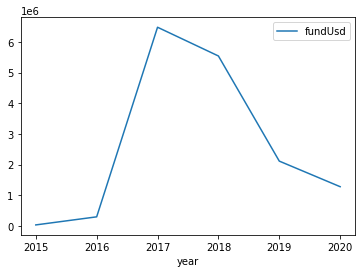

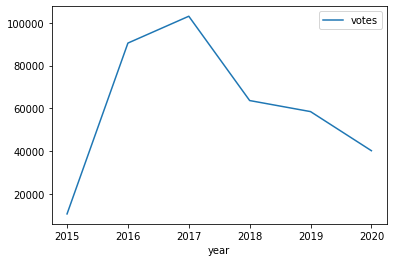

In [ ]:
analysis = analysis.sort_values('end')
funded = analysis[analysis['will_be_funded']]
funded.groupby('year').sum('fundUsd').sort_index().plot(y='fundUsd')
funded.groupby('year').sum('votes').sort_index().plot(y='votes')

### Latex Input

In [ ]:
first_proposal_date = proposals.sort_values("add").head(1)['add'].values[0].astype(str)[0: 10]
last_proposal_date = rates.sort_index().tail(1).index[0].date().isoformat()
print('\\newcommand{\\dashFirstProposal}[0]{\mbox{' + first_proposal_date + '}\\@\\xspace}')
print('\\newcommand{\\dashLastProposal}[0]{\mbox{' + last_proposal_date + '}\\@\\xspace}')
print('\\newcommand{\\dashProposals}[0]{\mbox{' + str(analysis.shape[0]) + '}\\@\\xspace}')
print('\\newcommand{\\dashProposalsWillBeFunded}[0]{\mbox{' + str(analysis[analysis["will_be_funded"] == True].shape[0]) + '}\\@\\xspace}')

\newcommand{\dashFirstProposal}[0]{\mbox{2015-08-27}\@\xspace}
\newcommand{\dashLastProposal}[0]{\mbox{2020-10-26}\@\xspace}
\newcommand{\dashProposals}[0]{\mbox{578}\@\xspace}
\newcommand{\dashProposalsWillBeFunded}[0]{\mbox{390}\@\xspace}


In [ ]:
successfulProposals = analysis[analysis['will_be_funded'] == True]
print('\\newcommand{\\dashFunded}[0]{$' + f'{successfulProposals["fund"].sum():n}'.replace(',', '\\,') + '$\\@\\xspace}')
print('\\newcommand{\\dashFundedUsd}[0]{$' + f'{successfulProposals["fundUsd"].sum() / 1000000:.1f}'.replace(',', '\\,') + '$\\@\\xspace}')



\newcommand{\dashFunded}[0]{$133\,901$\@\xspace}
\newcommand{\dashFundedUsd}[0]{$15.7$\@\xspace}


In [ ]:
analysis['count'] = 1
grouped = analysis.groupby('year').sum(['fundUsd', 'votes', 'count'])
grouped['fundUsd'] = grouped['fundUsd'].round().astype(int)
grouped['fund'] = grouped['fund'].round().astype(int)
grouped[['fundUsd', 'votes', 'yes', 'no', 'count']].to_csv()

'year,fundUsd,votes,yes,no,count\n2015,34208,12822,11156,1666,11\n2016,304947,99147,86171,12976,91\n2017,9915181,123749,106447,14240,171\n2018,16485710,77179,61765,13577,177\n2019,3315861,65606,53665,10358,84\n2020,1363793,43294,37131,5516,44\n'

In [ ]:
grouped

,will_be_funded,yes,no,abstain,votes,fund,rateDashUsd,fundUsd,count
year,,,,,,,,,
2015,10,11156,1666,0,12822,14174,26.59,34208,11
2016,86,86171,12976,0,99147,33884,842.24,304947,91
2017,123,106447,14240,3062,123749,48615,40154.15,9915181,171
2018,69,61765,13577,1837,77179,46484,83579.46,16485710,177
2019,61,53665,10358,1583,65606,33640,7971.89,3315861,84
2020,41,37131,5516,647,43294,16025,3745.45,1363793,44


# Bitcoin

In [ ]:
print('% Avg P2PKH transaction weight and stddev')
job = client.query('CREATE TEMP FUNCTION MEDIAN(arr ANY TYPE) AS ((SELECT IF(MOD(ARRAY_LENGTH(arr), 2) = 0, (arr[OFFSET(DIV(ARRAY_LENGTH(arr), 2) - 1)] + arr[OFFSET(DIV(ARRAY_LENGTH(arr), 2))]) / 2, arr[OFFSET(DIV(ARRAY_LENGTH(arr), 2))]) FROM (SELECT ARRAY_AGG(x ORDER BY x) AS arr FROM UNNEST(arr) AS x))); SELECT MEDIAN(ARRAY_AGG(virtual_size)) as virtual_size_median, STDDEV(virtual_size) virtual_size_std FROM `bigquery-public-data.crypto_bitcoin.transactions` WHERE input_count = 1 AND output_count = 1 AND size != virtual_size AND outputs[OFFSET(0)].type like "witness%keyhash" AND inputs[OFFSET(0)].type like "witness%keyhash" AND block_timestamp_month <= "2020-10-01"')
result = next(iter(job.result()))
print('\\newcommand{\\bitcoinPToPKHWeight}[0]{$' + f'{result[0]:n}'.replace(',', '\\,') + '$\\@\\xspace}')
print('\\newcommand{\\bitcoinPToPKHWeightStd}[0]{$' + f'{result[1]:.3f}'.replace(',', '\\,') + '$\\@\\xspace}')


% Avg P2PKH transaction weight and stddev
\newcommand{\bitcoinPToPKHWeight}[0]{$110$\@\xspace}
\newcommand{\bitcoinPToPKHWeightStd}[0]{$0.069$\@\xspace}


# Residual Capacities Analysis
Querying the residual capacities requires an advanced SQL script which is available at our Github respository. The measurement results are available in our gasMeasurements table. The median values in the paper are calculated as follows.

```sql
CREATE TEMP FUNCTION
  MEDIAN(arr ANY TYPE) AS ((
    SELECT
    IF
      (MOD(ARRAY_LENGTH(arr), 2) = 0,
        (arr[
        OFFSET
          (DIV(ARRAY_LENGTH(arr), 2) - 1)] + arr[
        OFFSET
          (DIV(ARRAY_LENGTH(arr), 2))]) / 2,
        arr[
      OFFSET
        (DIV(ARRAY_LENGTH(arr), 2))])
    FROM (
      SELECT
        ARRAY_AGG(x
        ORDER BY
          x) AS arr
      FROM
        UNNEST(arr) AS x)));

CREATE TEMP FUNCTION
  MAD(arr ANY TYPE) AS ((
    SELECT
    MEDIAN(
    ARRAY_AGG(
    ABS(MEDIAN(arr) - x)
    )
    )
    FROM
        UNNEST(arr) AS x
  ));
  
CREATE TEMP FUNCTION hhmm(num ANY TYPE) AS (
  FORMAT("%02d", CAST(FLOOR(num / 60) AS INT64)) || ":" || FORMAT("%02d", CAST(MOD(CAST(num as INT64), 60) AS INT64))
);


WITH evals AS
( SELECT 'Ethereum Na\\"ive' as name, 1 as sort, 21000 * 2000 as gas, 12 * POW(10, 6) as blocksize_limit, 15 as block_rate
  UNION ALL
  SELECT 'Ethereum Minimal Voting' as name, 2 as sort, 41897 * 2000 as gas, 12 * POW(10, 6) as blocksize_limit, 15 as block_rate
  UNION ALL
  SELECT 'Ethereum \\emph{The DAO}' as name, 3 as sort, 150000 * 2000 as gas, 12 * POW(10, 6) as blocksize_limit, 15 as block_rate
  UNION ALL
  SELECT 'Bitcoin Na\\"ive' as name, 4 as sort, 110 * 2000 as gas, 4000000 as blocksize_limit, 600 as block_rate
  UNION ALL
  SELECT 'Dash' as name, 4.5 as sort, 191 * 2000 as gas, 2000000 as blocksize_limit, 150 as block_rate

  UNION ALL
  SELECT 'Ethereum Na\\"ive' as name, 5 as sort, 21000 * 100000 as gas, 12 * POW(10, 6) as blocksize_limit, 15 as block_rate
  UNION ALL
  SELECT 'Ethereum Minimal Voting' as name, 6 as sort, 41897 * 100000 as gas, 12 * POW(10, 6) as blocksize_limit, 15 as block_rate
  UNION ALL
  SELECT 'Ethereum \\emph{The DAO}' as name, 7 as sort, 150000 * 100000 as gas, 12 * POW(10, 6) as blocksize_limit, 15 as block_rate
  UNION ALL
  SELECT 'Bitcoin Na\\"ive' as name, 8 as sort, 110 * 100000 as gas, 4000000 as blocksize_limit, 600 as block_rate
  UNION ALL
  SELECT 'Dash' as name, 9 as sort, 191 * 100000 as gas, 2000000 as blocksize_limit, 150 as block_rate
)

SELECT ' & ' || name
  || ' & ' || CEIL(gas / blocksize_limit)
  || ' & ' || CEIL(blocks_median)
  || ' & ' || CEIL(blocks_mad)
  || ' & '
  || ' & ' || hhmm(CEIL(CEIL(gas / blocksize_limit) * block_rate / 60))
  || ' & ' || hhmm(CEIL(duration_median))
  || ' & ' || hhmm(CEIL(duration_mad))
  || ' \\\\'



FROM (

SELECT
  (SELECT name FROM evals WHERE evals.gas = gasMeasurements.gas) as name,
  (SELECT sort FROM evals WHERE evals.gas = gasMeasurements.gas) as sort,
  (SELECT blocksize_limit FROM evals WHERE evals.gas = gasMeasurements.gas) as blocksize_limit,
  (SELECT block_rate FROM evals WHERE evals.gas = gasMeasurements.gas) as block_rate,
  gasMeasurements.gas as gas,
  MEDIAN(ARRAY_AGG(blocks)) as blocks_median,
  stddev(blocks) as blocks_stdev,
  MAD(ARRAY_AGG(blocks)) as blocks_mad,
  MEDIAN(ARRAY_AGG(duration)) as duration_median,
  stddev(duration) as duration_stdev,
  MAD(ARRAY_AGG(duration)) as duration_mad,
  COUNT(*) as measurements
FROM
  `evotinggasanalysis.20201027.gasMeasurements` gasMeasurements
group by gasMeasurements.gas
ORDER BY sort ASC
)
```


# Latex Input
This section executes SQL analysis queries as latex inputs for our paper.

In [ ]:
print('% Number of method hashes (aka signatures)')
signaturesCount = votingSigns.shape[0]
print('\\newcommand{\\signatures}[0]{$' + f'{signaturesCount:n}'.replace(',', '\\,') + '$\\@\\xspace}')

print('% Number of voting smart contracts (with methods > 1 and unique by their address)')
job = client.query('SELECT SUM(count) FROM ( SELECT substr(cast(date(votingContract.block_timestamp) as string), 0, 4) as year, count(*) as count FROM `evotinggasanalysis.{0}.votingContracts` votingContract, `evotinggasanalysis.{0}.votingContractMethods` count WHERE 1=1 AND count.address = votingContract.address AND count.voting_methods > 1 AND DATE(votingContract.block_timestamp) <= \'{1}\' group by year order by year ASC )'.format(dataset, maxBlock))
result = job.result()
deployedVotingSmartContracts = next(iter(result))[0]
print('\\newcommand{\\deployedVotingSmartContracts}[0]{$' + f'{deployedVotingSmartContracts:n}'.replace(',', '\\,') + '$\\@\\xspace}')

print('% ... and the sum of their Ether balanaces')
job = client.query('SELECT SUM(balances.eth_balance / 1000000000000000000) AS balance, FROM `evotinggasanalysis.{0}.votingContracts` votingContract, `evotinggasanalysis.{0}.votingContractMethods` count, bigquery-public-data.crypto_ethereum.balances balances WHERE count.address = votingContract.address AND votingContract.address = balances.address AND count.voting_methods > 1 AND DATE(votingContract.block_timestamp) <= \'{1}\''.format(dataset, maxBlock))
result = job.result()
deployedVotingSmartContractsBalanaces = int(next(iter(result))[0])
print('\\newcommand{\\deployedVotingSmartContractsBalanaces}[0]{$' + f'{deployedVotingSmartContractsBalanaces:n}'.replace(',', '\\,') + '$\\@\\xspace}')


% Number of method hashes (aka signatures)
\newcommand{\signatures}[0]{$1\,472$\@\xspace}
% Number of voting smart contracts (with methods > 1 and unique by their address)
\newcommand{\deployedVotingSmartContracts}[0]{$3\,386$\@\xspace}
% ... and the sum of their Ether balanaces
\newcommand{\deployedVotingSmartContractsBalanaces}[0]{$12\,064$\@\xspace}


In [ ]:
job = client.query('SELECT SUM(transactions.value / 1000000000000000000) AS txs_balance, FROM `evotinggasanalysis.{0}.votingContracts` votingContract, `evotinggasanalysis.{0}.votingContractMethods` count, bigquery-public-data.crypto_ethereum.transactions transactions WHERE 1=1 AND count.address = votingContract.address AND count.voting_methods > 1 AND DATE(transactions.block_timestamp) <= \'{1}\' AND transactions.to_address = votingContract.address'.format(dataset, maxBlock))
result = job.result()
deployedVotingSmartContractsReceivedEther = int(next(iter(result))[0])
print('\\newcommand{\\deployedVotingSmartContractsReceivedEther}[0]{$' + f'{deployedVotingSmartContractsReceivedEther:n}'.replace(',', '\\,') + '$\\@\\xspace}')

\newcommand{\deployedVotingSmartContractsReceivedEther}[0]{$12\,094\,205$\@\xspace}


In [ ]:
job = client.query('SELECT COUNT(*) FROM evotinggasanalysis.{0}.votingContracts contracts, evotinggasanalysis.{0}.votingContractMethods count, bigquery-public-data.crypto_ethereum.transactions transactions WHERE DATE(contracts.block_timestamp) <= \'{1}\' AND DATE(transactions.block_timestamp) <= \'{1}\' AND count.address = contracts.address AND count.voting_methods >  1 AND contracts.address = transactions.to_address'.format(dataset, maxBlock))
result = job.result()
allTransactionsToVotingSmartContracts = int(next(iter(result))[0])
print('\\newcommand{\\allTransactionsToVotingSmartContracts}[0]{$' + f'{allTransactionsToVotingSmartContracts:n}'.replace(',', '\\,') + '$\\@\\xspace}')

\newcommand{\allTransactionsToVotingSmartContracts}[0]{$788\,820$\@\xspace}


In [ ]:
job = client.query('SELECT COUNT(*) FROM evotinggasanalysis.{0}.votingTransactions WHERE DATE(block_timestamp) <= \'{1}\''.format(dataset, maxBlock))
result = job.result()
votingTransactions = int(next(iter(result))[0])
print('\\newcommand{\\votingTransactions}[0]{$' + f'{votingTransactions:n}'.replace(',', '\\,') + '$\\@\\xspace}')

\newcommand{\votingTransactions}[0]{$130\,152$\@\xspace}


In [ ]:
job = client.query('SELECT COUNT(*) FROM `bigquery-public-data`.crypto_ethereum.transactions WHERE (receipt_status IS NULL OR receipt_status = 1) AND DATE(block_timestamp) <= \'{1}\' AND to_address IN ( SELECT DISTINCT to_address FROM evotinggasanalysis.{0}.votingTransactions)'.format(dataset, maxBlock))
result = job.result()
allTransactionsToVotingSmartContracts = int(next(iter(result))[0])
print('\\newcommand{\\allTransactionsToVotingSmartContracts}[0]{$' + f'{allTransactionsToVotingSmartContracts:n}'.replace(',', '\\,') + '$\\@\\xspace}')

\newcommand{\allTransactionsToVotingSmartContracts}[0]{$1\,459\,327$\@\xspace}


In [ ]:
job = client.query('SELECT count(*) as count FROM `evotinggasanalysis.{0}.votingContracts` votingContract, `evotinggasanalysis.{0}.votingContractMethods` count WHERE 1=1 AND count.address = votingContract.address AND count.voting_methods > 1 AND DATE(votingContract.block_timestamp) <= \'{1}\''.format(dataset, maxBlock))
result = job.result()
votingSmartContractsWithMoreThanOneMethod = int(next(iter(result))[0])
print('\\newcommand{\\votingSmartContractsWithMoreThanOneMethod}[0]{$' + f'{votingSmartContractsWithMoreThanOneMethod:n}'.replace(',', '\\,') + '$\\@\\xspace}')

\newcommand{\votingSmartContractsWithMoreThanOneMethod}[0]{$3\,386$\@\xspace}


In [ ]:
job = client.query('SELECT COUNT(votingTransactions.function_sighash) calls, votingTransactions.function_sighash sig_hash, functionSighashes.signature signature, (SELECT SUM(t.receipt_gas_used) FROM `evotinggasanalysis.{0}.votingTransactions` t WHERE t.function_sighash = votingTransactions.function_sighash) as sum_tx_gas, (SELECT SUM(t.receipt_gas_used) FROM `evotinggasanalysis.{0}.votingTransactions` t WHERE t.function_sighash = votingTransactions.function_sighash) / COUNT(votingTransactions.function_sighash) as gas_per_call_avg, CAST((SELECT SUM(t.gas_price) FROM `evotinggasanalysis.{0}.votingTransactions` t WHERE t.function_sighash = votingTransactions.function_sighash) / COUNT(votingTransactions.function_sighash) as INT64) as gas_price_per_call_avg, (SELECT SUM(t.value) FROM `evotinggasanalysis.{0}.votingTransactions` t WHERE t.function_sighash = votingTransactions.function_sighash) / 1000000000000000000 as sum_tx_value, FROM evotinggasanalysis.{0}.votingTransactions votingTransactions, evotinggasanalysis.{0}.functionSighashes functionSighashes WHERE functionSighashes.hash = votingTransactions.function_sighash and date(votingTransactions.block_timestamp) <= \'{1}\' GROUP BY votingTransactions.function_sighash, functionSighashes.signature ORDER BY calls DESC LIMIT 10'.format(dataset, maxBlock))
result = job.result()
result

In [ ]:
i = 1
for row in result: # calls, sig_hash, signature, sum_tx_gas, gas_per_call_avg, gas_price_per_call_avg, sum_tx_value
  print(str(i) + ' & ', end='')
  print(f'{int(row[0]):n} \t& '.replace(',', '\,'), end='')
  print('\\texttt{' + str(row[1]) + '} & ', end='')
  print('\\texttt{' + str(row[2]) + '} & ', end='')
  print(f'{row[4]/1000:.0f}'.replace(',', '\,') + '\,k & ', end='')
  print(f'{row[5]/1000000000:.1f}'.replace(',', '\,'), end='')
  print('\,Gwei \\\\')
  i += 1

1 & 80\,676 	& \texttt{0x0121b93f} & \texttt{vote(uint256)} & 71\,k & 2.4\,Gwei \\
2 & 6\,996 	& \texttt{0xb384abef} & \texttt{vote(uint256,uint256)} & 32\,k & 28.8\,Gwei \\
3 & 6\,420 	& \texttt{0xfc36e15b} & \texttt{vote(string)} & 32\,k & 3.2\,Gwei \\
4 & 4\,534 	& \texttt{0xddb6e116} & \texttt{vote(uint16)} & 47\,k & 3.7\,Gwei \\
5 & 2\,930 	& \texttt{0x6cbf9c5e} & \texttt{commitVote(uint256,bytes32,uint256,uint256)} & 164\,k & 3.8\,Gwei \\
6 & 2\,624 	& \texttt{0x5e8254ea} & \texttt{commitVoteOnProposal(bytes32,uint8,bytes32)} & 110\,k & 7.0\,Gwei \\
7 & 2\,161 	& \texttt{0x9ef1204c} & \texttt{vote(bytes32,uint256)} & 151\,k & 9.6\,Gwei \\
8 & 2\,124 	& \texttt{0xcff9293a} & \texttt{vote(uint32,uint32)} & 51\,k & 12.1\,Gwei \\
9 & 2\,009 	& \texttt{0xb11d8bb8} & \texttt{revealVote(uint256,uint256,uint256)} & 62\,k & 3.4\,Gwei \\
10 & 1\,817 	& \texttt{0x3850f804} & \texttt{castVote(uint256,uint256[],uint256,uint256)} & 165\,k & 48.8\,Gwei \\


In [ ]:
job = client.query('SELECT votingContract.address, (SELECT SUM(value) / 1000000000000000000 FROM `bigquery-public-data`.crypto_ethereum.traces WHERE status = 1 AND to_address = votingContract.address and date(block_timestamp) < \'{1}\') as received_ether, (SELECT SUM(value) / 1000000000000000000 FROM `bigquery-public-data`.crypto_ethereum.traces WHERE status = 1 AND to_address = votingContract.address and date(block_timestamp) <= \'{1}\') - IFNULL((SELECT SUM(value) / 1000000000000000000 FROM `bigquery-public-data`.crypto_ethereum.traces WHERE status = 1 AND from_address = votingContract.address and date(block_timestamp) <= \'{1}\'),0) as balance_ether FROM `evotinggasanalysis.{0}.votingContracts` votingContract , bigquery-public-data.crypto_ethereum.balances balances , `evotinggasanalysis.{0}.votingContractMethods` count WHERE 1=1 AND date(votingContract.block_timestamp) <= \'{1}\' AND votingContract.address = balances.address AND count.address = votingContract.address AND count.voting_methods > 1 group by  votingContract.address order by balance_ether DESC limit 4 '.format(dataset, maxBlock))
result = job.result()
result

In [ ]:
# file: table_contractsEther.tex
i = 1
for row in result: # address, received_ether, balance_ether
  name = row[0].replace('0x3de0c040705d50d62d1c36bde0ccbad20606515a', 'N/A (Congress Contract)').replace('0xfb6916095ca1df60bb79ce92ce3ea74c37c5d359', 'Unicorn Token (Congress Contract)').replace('0x9fa8fa61a10ff892e4ebceb7f4e0fc684c2ce0a9', 'HONG / hongcoin').replace('0xdbf03b407c01e7cd3cbea99509d93f8dddc8c6fb', 'Dogecoin-Ethereum Bounty')
  print(str(i) + ' & ', end='')
  print(name + ' & ', end='')
  print(f'{int(row[1]):n}'.replace(',', '\,') + ' & ', end='')
  print(f'{int(row[2]):n}'.replace(',', '\,') + ' (\\$ ', end='')
  print(f'{int(row[2]*383/1000):n}'.replace(',', '\,') + '\\,k) \\\\')
  print('  & \\texttt{' + row[0] + '} \\\\')

  i += 1

1 & N/A (Congress Contract) & 5\,028 & 5\,010 (\$ 1\,918\,k) \\
  & \texttt{0x3de0c040705d50d62d1c36bde0ccbad20606515a} \\
2 & Unicorn Token (Congress Contract) & 5\,891 & 4\,595 (\$ 1\,760\,k) \\
  & \texttt{0xfb6916095ca1df60bb79ce92ce3ea74c37c5d359} \\
3 & HONG / hongcoin & 3\,936 & 1\,003 (\$ 384\,k) \\
  & \texttt{0x9fa8fa61a10ff892e4ebceb7f4e0fc684c2ce0a9} \\
4 & Dogecoin-Ethereum Bounty & 6\,592 & 597 (\$ 228\,k) \\
  & \texttt{0xdbf03b407c01e7cd3cbea99509d93f8dddc8c6fb} \\


In [ ]:
job = client.query('SELECT COUNT(*) FROM ( SELECT votingContract.address, (SELECT CAST(SUM(value) / 1000000000000000000 AS INT64) FROM `bigquery-public-data`.crypto_ethereum.traces WHERE status = 1 AND to_address = votingContract.address and date(block_timestamp) < \'{1}\') as received_ether, CAST((SELECT SUM(value) / 1000000000000000000 FROM `bigquery-public-data`.crypto_ethereum.traces WHERE status = 1 AND to_address = votingContract.address and date(block_timestamp) <= \'{1}\') - IFNULL((SELECT 0 + SUM(value) / 1000000000000000000 FROM `bigquery-public-data`.crypto_ethereum.traces WHERE status = 1 AND from_address = votingContract.address and date(block_timestamp) <= \'{1}\'),0) AS INT64) as balance_ether FROM `evotinggasanalysis.{0}.votingContracts` votingContract , bigquery-public-data.crypto_ethereum.balances balances , `evotinggasanalysis.{0}.votingContractMethods` count WHERE 1=1 AND date(votingContract.block_timestamp) <= \'{1}\' AND votingContract.address = balances.address AND count.address = votingContract.address AND count.voting_methods > 1 group by votingContract.address order by received_ether DESC ) '.format(dataset, maxBlock))
result = job.result()
votingSmartContractsWhichReceivedEther = int(next(iter(result))[0])
print('\\newcommand{\\votingSmartContractsWhichReceivedEther}[0]{$' + f'{votingSmartContractsWhichReceivedEther:n}'.replace(',', '\\,') + '$\\@\\xspace}')

\newcommand{\votingSmartContractsWhichReceivedEther}[0]{$3\,335$\@\xspace}


In [ ]:
job = client.query('SELECT *, deposited - withdrawn as balance, ROUND((deposited - withdrawn) * 100 / deposited, 2) as balance_percent FROM ( SELECT ( SELECT CAST(SUM(value) / POW(10, 18) AS INT64) FROM  `bigquery-public-data.crypto_ethereum.traces` txs WHERE 1=1 AND txs.status = 1 AND DATE(txs.block_timestamp) <= \'{1}\' AND txs.to_address IN ( SELECT contracts.address FROM `evotinggasanalysis.{0}.votingContracts` contracts, `evotinggasanalysis.{0}.votingContractMethods` methods WHERE contracts.address = methods.address AND methods.voting_methods > 1 ) ) as deposited, ( SELECT CAST(SUM(value) / POW(10, 18) AS INT64) FROM  `bigquery-public-data.crypto_ethereum.traces` txs WHERE 1=1 AND txs.status = 1 AND DATE(txs.block_timestamp) <= \'{1}\' AND txs.from_address IN ( SELECT contracts.address FROM `evotinggasanalysis.{0}.votingContracts` contracts, `evotinggasanalysis.{0}.votingContractMethods` methods WHERE contracts.address = methods.address AND methods.voting_methods > 1 ) ) as withdrawn ) '.format(dataset, maxBlock))
result = job.result()
row = next(iter(result))
votingSmartContractsTotalDeposits = int(row[0])
votingSmartContractsTotalWithdrawls = int(row[1])
votingSmartContractsTotalBalance = int(row[2])
votingSmartContractsTotalBalancePercent = float(row[3])
print('\\newcommand{\\votingSmartContractsTotalDeposits}[0]{$' + f'{votingSmartContractsTotalDeposits:n}'.replace(',', '\\,') + '$\\@\\xspace}')
print('\\newcommand{\\votingSmartContractsTotalWithdrawls}[0]{$' + f'{votingSmartContractsTotalWithdrawls:n}'.replace(',', '\\,') + '$\\@\\xspace}')
print('\\newcommand{\\votingSmartContractsTotalBalance}[0]{$' + f'{votingSmartContractsTotalBalance:n}'.replace(',', '\\,') + '$\\@\\xspace}')
print('\\newcommand{\\votingSmartContractsTotalBalancePercent}[0]{$' + f'{votingSmartContractsTotalBalancePercent:.2f}'.replace(',', '\\,') + '$\\@\\xspace}')


\newcommand{\votingSmartContractsTotalDeposits}[0]{$24\,723\,295$\@\xspace}
\newcommand{\votingSmartContractsTotalWithdrawls}[0]{$24\,711\,182$\@\xspace}
\newcommand{\votingSmartContractsTotalBalance}[0]{$12\,113$\@\xspace}
\newcommand{\votingSmartContractsTotalBalancePercent}[0]{$0.05$\@\xspace}


In [ ]:
daoHashes = votingSigns[votingSigns["source"] == "The DAO"].hash
daoHashesWHERE = ' AND '.join(list(daoHashes.apply(lambda x: '\'' + x + '\' IN UNNEST(function_sighashes)').astype('string').values))
job = client.query('SELECT COUNT(*) FROM `bigquery-public-data.crypto_ethereum.contracts` WHERE ' + daoHashesWHERE)
result = job.result()
deployedTheDAOContracts = int(next(iter(result))[0])
print('\\newcommand{\\theDAOContractsDeployments}[0]{$' + f'{deployedTheDAOContracts:n}'.replace(',', '\\,') + '$\\@\\xspace}')


\newcommand{\theDAOContractsDeployments}[0]{$88$\@\xspace}


In [ ]:
job = client.query('CREATE TEMP FUNCTION MEDIAN(arr ANY TYPE) AS ((SELECT IF(MOD(ARRAY_LENGTH(arr), 2) = 0, (arr[OFFSET(DIV(ARRAY_LENGTH(arr), 2) - 1)] + arr[OFFSET(DIV(ARRAY_LENGTH(arr), 2))]) / 2, arr[OFFSET(DIV(ARRAY_LENGTH(arr), 2))]) FROM (SELECT ARRAY_AGG(x ORDER BY x) AS arr FROM UNNEST(arr) AS x))); SELECT COUNT(*), MEDIAN(ARRAY_AGG(gas)), MEDIAN(ARRAY_AGG(gas_price)) FROM `bigquery-public-data.crypto_ethereum.transactions` WHERE  SUBSTR(input, 0, 10) = "0xc9d27afe" AND to_address IN (SELECT address FROM `bigquery-public-data.crypto_ethereum.contracts` WHERE' + daoHashesWHERE + ')')
result = job.result()
row = next(iter(result))
theDAOContractsVotingTransactions = int(row[0])
theDAOContractsVotingTransactionsGasMedian = int(row[1])
theDAOContractsVotingTransactionsGaspriceMedian = int(row[2])
print('\\newcommand{\\theDAOContractsVotingTransactions}[0]{$' + f'{theDAOContractsVotingTransactions:n}'.replace(',', '\\,') + '$\\@\\xspace}')
print('\\newcommand{\\theDAOContractsVotingTransactionsGasMedian}[0]{$' + f'{theDAOContractsVotingTransactionsGasMedian:n}'.replace(',', '\\,') + '$\\@\\xspace}')
print('\\newcommand{\\theDAOContractsVotingTransactionsGaspriceMedian}[0]{$' + f'{theDAOContractsVotingTransactionsGaspriceMedian:n}'.replace(',', '\\,') + '$\\@\\xspace}')

\newcommand{\theDAOContractsVotingTransactions}[0]{$5\,928$\@\xspace}
\newcommand{\theDAOContractsVotingTransactionsGasMedian}[0]{$150\,000$\@\xspace}
\newcommand{\theDAOContractsVotingTransactionsGaspriceMedian}[0]{$21\,000\,000\,000$\@\xspace}
